In [2]:
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 78.2 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 MB 37.8 MB/s eta 0:00:00:00:0100:01


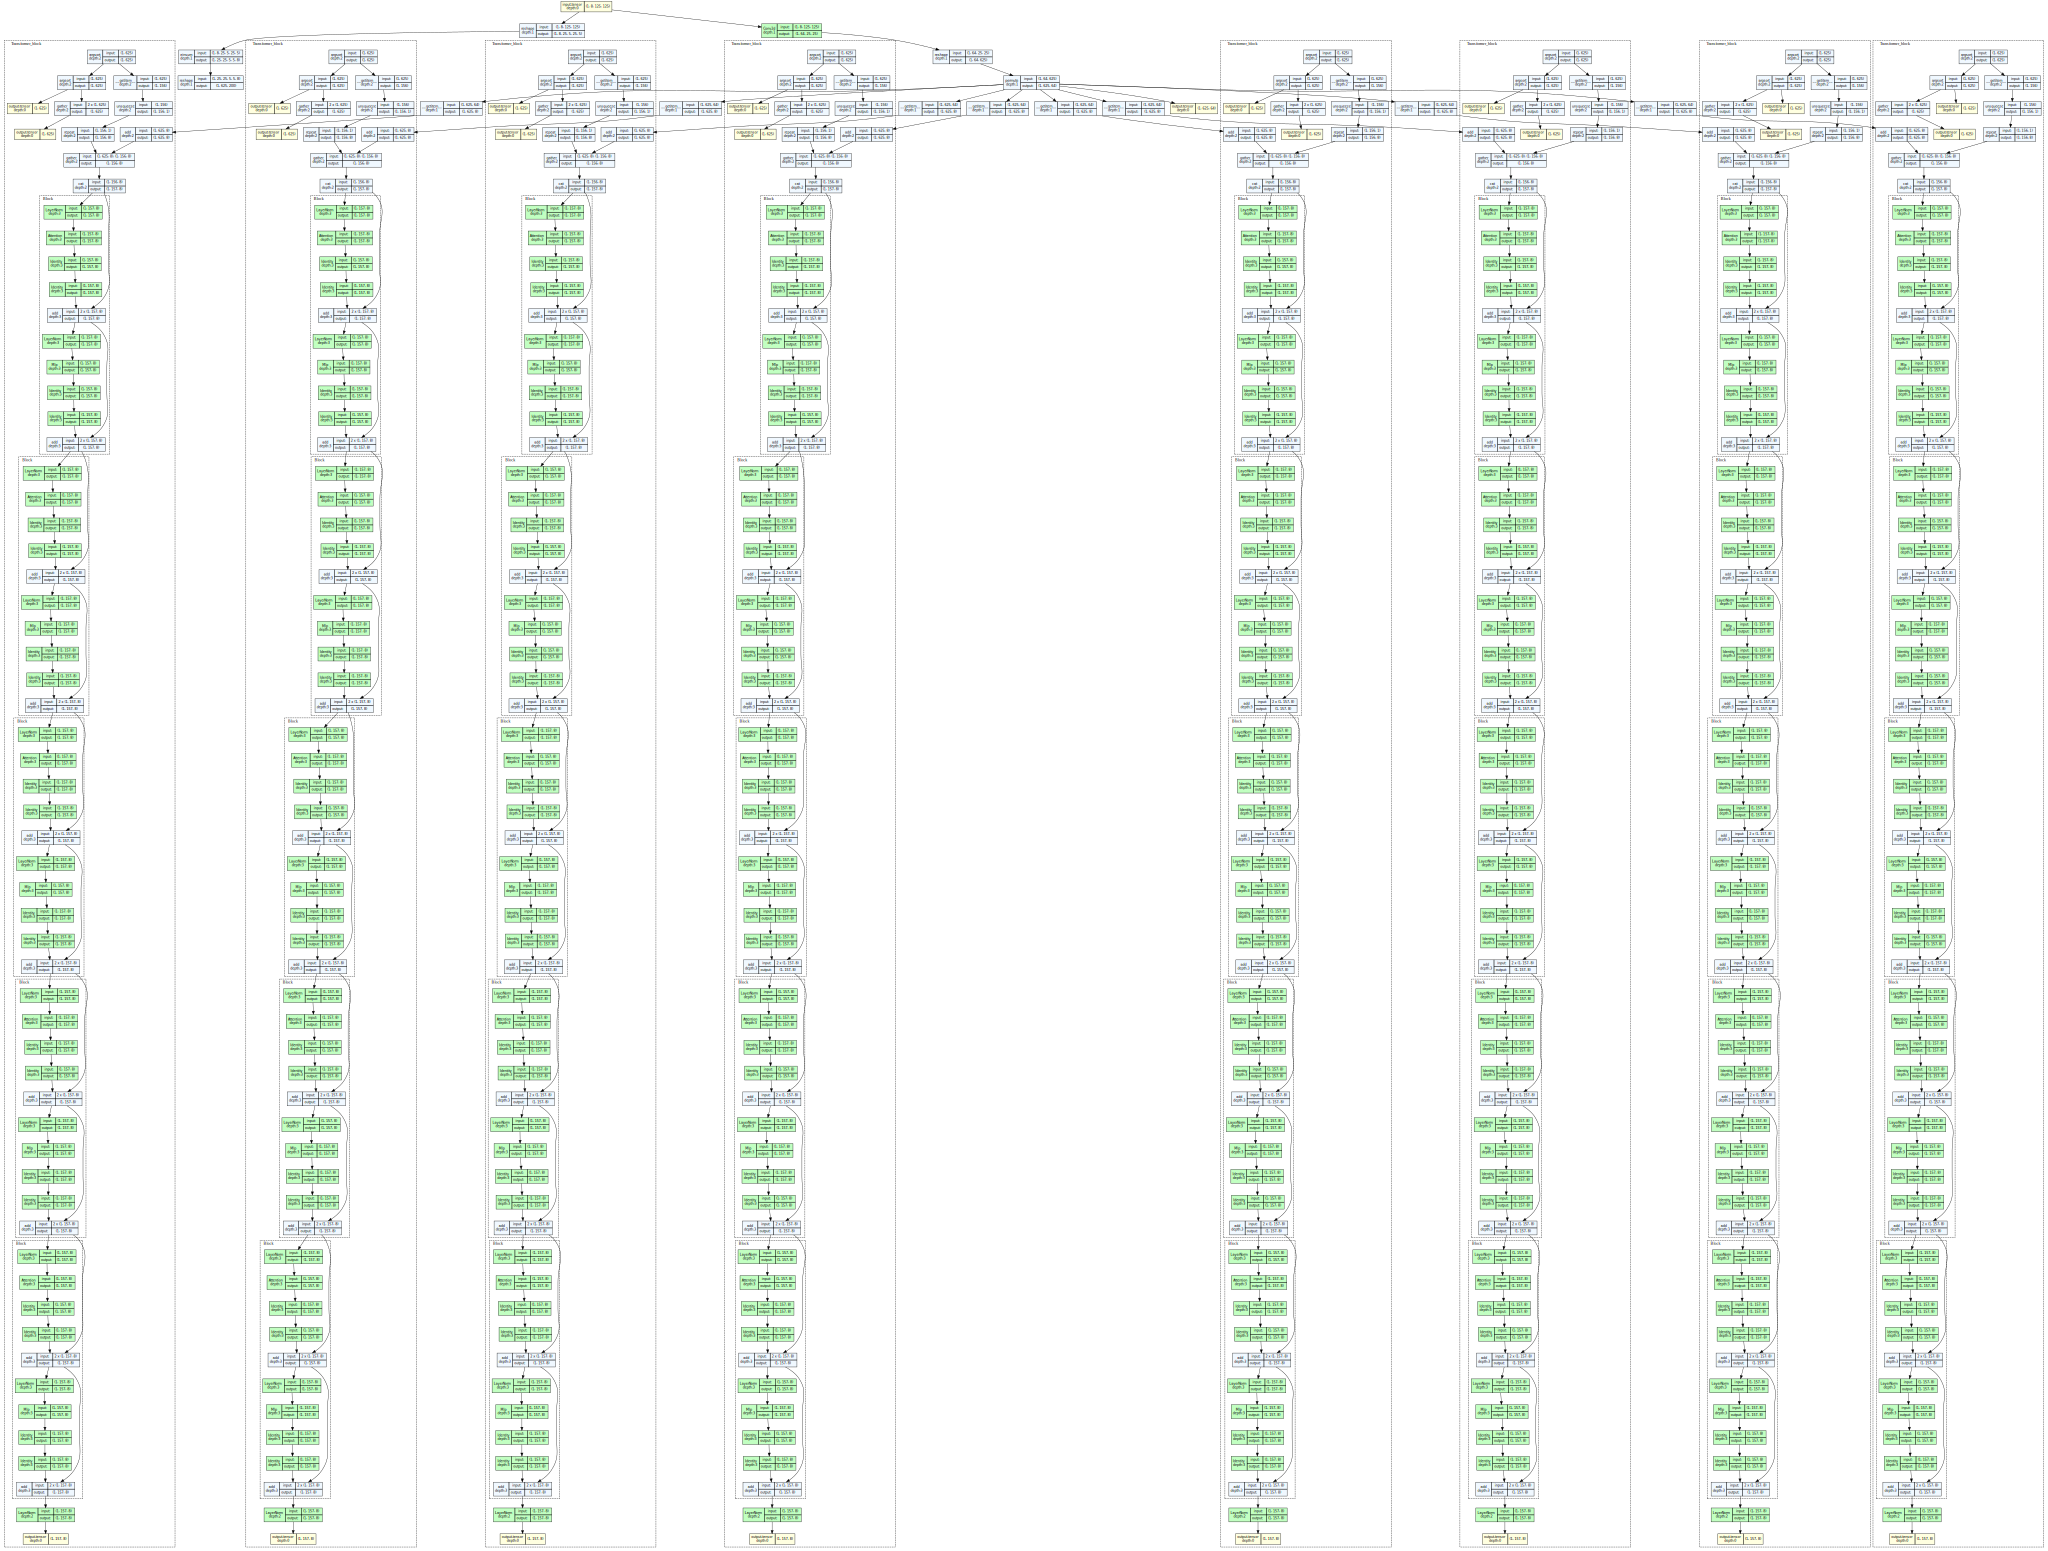

In [3]:
import numpy as np
import torch
import torch_xla
import torch_xla.core.xla_model as xm

import pandas as pd
import numpy as np
import csv
import torch
import ctypes
import gc
import os

import dataset
import torch
import warnings

import pandas as pd
import numpy as np
import torch.nn as nn

from sklearn import metrics
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
torch.manual_seed(42)
os.environ['PJRT_DEVICE'] = 'TPU' 
warnings.filterwarnings("ignore")
libc = ctypes.CDLL("libc.so.6")
import torch

import numpy as np

import torch

def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype='float32')
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

from functools import partial

import torch
import torch.nn as nn

from timm.models.vision_transformer import PatchEmbed, Block

class Transformer_block(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=8,embed_dim=1024, depth=24,
                 num_heads=16, mlp_ratio=4,norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()

        # --------------------------------------------------------------------------
        # MAE encoder specifics
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(depth)])
        
        self.norm = norm_layer(embed_dim)

        self.initialize_weights()
        

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.cls_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        
    def patchify(self, imgs):
        """
        imgs: (N, 8, H, W)
        x: (N, L, patch_size**2 *3)
        """
        p = self.patch_embed.patch_size[0]
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 8, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 8))
        return x

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 8, H, W)
        """
        p = self.patch_embed.patch_size[0]
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 8))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 8, h * p, h * p))
        return imgs

    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        
        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore
    
    def forward(self, x, mask_ratio = 0.75):

        # add pos embed w/o cls token
        x = x + self.pos_embed[:, 1:, :]

        # masking: length -> length * mask_ratio
        x, mask, ids_restore = self.random_masking(x, mask_ratio)

        # append cls toke1
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        
        return x, mask, ids_restore
    
class Encoder(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=8,
                 embed_dim=1024, depth=24, num_heads=16,k_factor = 32,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        
        super().__init__()
        self.patch_embed = nn.Conv2d(
            in_channels=8, groups=8, out_channels=8*k_factor, kernel_size=patch_size, stride=patch_size
        )
        
        self.blocks = nn.ModuleList([
            Transformer_block(img_size=img_size, patch_size=patch_size, in_chans=1,
                 embed_dim=embed_dim, depth=depth, num_heads=num_heads,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False)
            for _ in range(8)
        ])

        
    def _preprocess(self, x):
        batch_size, embed_dim, n_h, n_w = x.shape
        x = x.reshape(batch_size, embed_dim, n_h*n_w)
        x = x.permute(0,2,1)
        return x
        
    def forward(self, x, mask_ratio = 0.75):
        encoded_tensor = []
        masks = []
        ids = []
        imgs = []
        
        conv_proj = self._preprocess(self.patch_embed(x))
        batch_size, seq_len, encoded_latent_size = conv_proj.shape
        encoded_latent_size_per_channel = encoded_latent_size//8
        
        for i in range(8):
            encoded_latent = conv_proj[:,:,i*encoded_latent_size_per_channel:(i+1)*encoded_latent_size_per_channel]
            op, mask, ids_restore = self.blocks[i](encoded_latent, mask_ratio)
            encoded_tensor.append(op)
            masks.append(mask)
            ids.append(ids_restore)
 
        img = self.blocks[0].patchify(x)
        
        return encoded_tensor, masks, ids, conv_proj
    
import torchvision
from torchview import draw_graph
from torchviz import make_dot
encoder = Encoder(
    img_size=125, patch_size=5, in_chans = 1,k_factor = 8, embed_dim=8, depth=5, num_heads=8,
    mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6))

model_graph = draw_graph(encoder, input_size=(1,8,125,125), expand_nested=True)
model_graph.visual_graph

In [4]:
      
class Decoder_transformer_block(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=8,
                 embed_dim=1024, depth=24, num_heads=16,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()

        self.num_patches = (img_size//patch_size)**2
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(decoder_depth)])

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * 8, bias=True) # decoder to patch
        # --------------------------------------------------------------------------

        self.norm_pix_loss = norm_pix_loss

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding

        decoder_pos_embed = get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], int(self.num_patches**.5), cls_token=True)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.mask_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def patchify(self, imgs):
        """
        imgs: (N, 8, H, W)
        x: (N, L, patch_size**2 *3)
        """
        p = self.patch_embed.patch_size[0]
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 8, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 8))
        return x

    def forward(self, x):
        # embed tokens
        x = self.decoder_embed(x)

        # add pos embed
        x = x + self.decoder_pos_embed

        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        return x
    
class Decoder_block(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=8,embed_dim=1024,
             decoder_embed_dim=25, decoder_depth=8, decoder_num_heads=16,
             mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()

        self.decoder_depth = decoder_depth
        self.block = Decoder_transformer_block(img_size=img_size, patch_size=patch_size, in_chans=in_chans,
                                                 embed_dim=decoder_embed_dim,decoder_embed_dim=decoder_embed_dim, 
                                                 decoder_num_heads=decoder_num_heads, mlp_ratio=4, decoder_depth=decoder_depth,
                                                 norm_layer=nn.LayerNorm, norm_pix_loss=False)
                
        self.mask_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        
    def forward(self, x, ids):
        
        mask_tokens = self.mask_token.repeat(x.shape[0], ids.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
        cls_token = (x[:,:1,:])
        x_ = torch.gather(x_, dim=1, index=ids.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle

        op = torch.cat([cls_token, x_], dim=1)
        op = self.block(op)
        
        return op

class Decoder(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=8,
             embed_dim=1024, depth=24, num_heads=16,
             decoder_embed_dim=None, decoder_depth=8, decoder_num_heads=[8,8,8,8,8],
             mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()
        
        self.patch_size = patch_size
        self.decoder_depth = decoder_depth
        self.block = Decoder_block(img_size=125, patch_size=patch_size, embed_dim=embed_dim,in_chans = 1,
                                    decoder_embed_dim=decoder_embed_dim, decoder_depth=decoder_depth, decoder_num_heads=decoder_num_heads,
                                    mlp_ratio=mlp_ratio, norm_layer=norm_layer)
                 
        self.linear = nn.Linear(in_features = 16, out_features = 25)
        
    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *8)
        imgs: (N, 8, H, W)
        """
        p = self.patch_size
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 1))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 1, h * p, h * p))
        return imgs
    
    def forward(self, x, ids):
        op = []
        for i in range(8):
            lo = self.block(x[i], ids[i])
            lo = self.linear(lo)
            lo = self.unpatchify(lo[:,1:,:])
            op.append(lo)
        return op


In [3]:
class Masked_VIT(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder

    def forward_loss(self, target, pred):
        """
        imgs: [N, C, H, W]
        pred: [N, L, p*p*C]
        mask: [N, L], 0 is keep, 1 is remove,
        """
        pred = torch.cat(pred, axis = 1)
        # print(pred.shape)
        # print(target.shape)
        criterion = nn.BCEWithLogitsLoss(reduction = "mean")
        loss = criterion(pred, target)
        return loss
        
    def forward(self, x, mask_ratio = 0.75):
        encoded_tensor, mask, ids_restore, patchified_img = self.encoder(x, mask_ratio)
        pred = self.decoder(encoded_tensor, ids_restore)
        loss = self.forward_loss(x, pred)
        return pred, loss
    
def mae_vit_base_patch16_dec512d8b(**kwargs):
    encoder = Encoder(
        img_size=125, patch_size=5, embed_dim=16,k_factor = 16, depth=10, num_heads=8, in_chans = 1,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    
    decoder = Decoder(
        img_size=125, patch_size=5, embed_dim=16, in_chans = 1,
        decoder_embed_dim=16, decoder_depth=6, decoder_num_heads=4,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    
    model = Masked_VIT(encoder, decoder)
    
    return model

# Instantiate the model
model = mae_vit_base_patch16_dec512d8b()
model.load_state_dict(torch.load(''))

<All keys matched successfully>

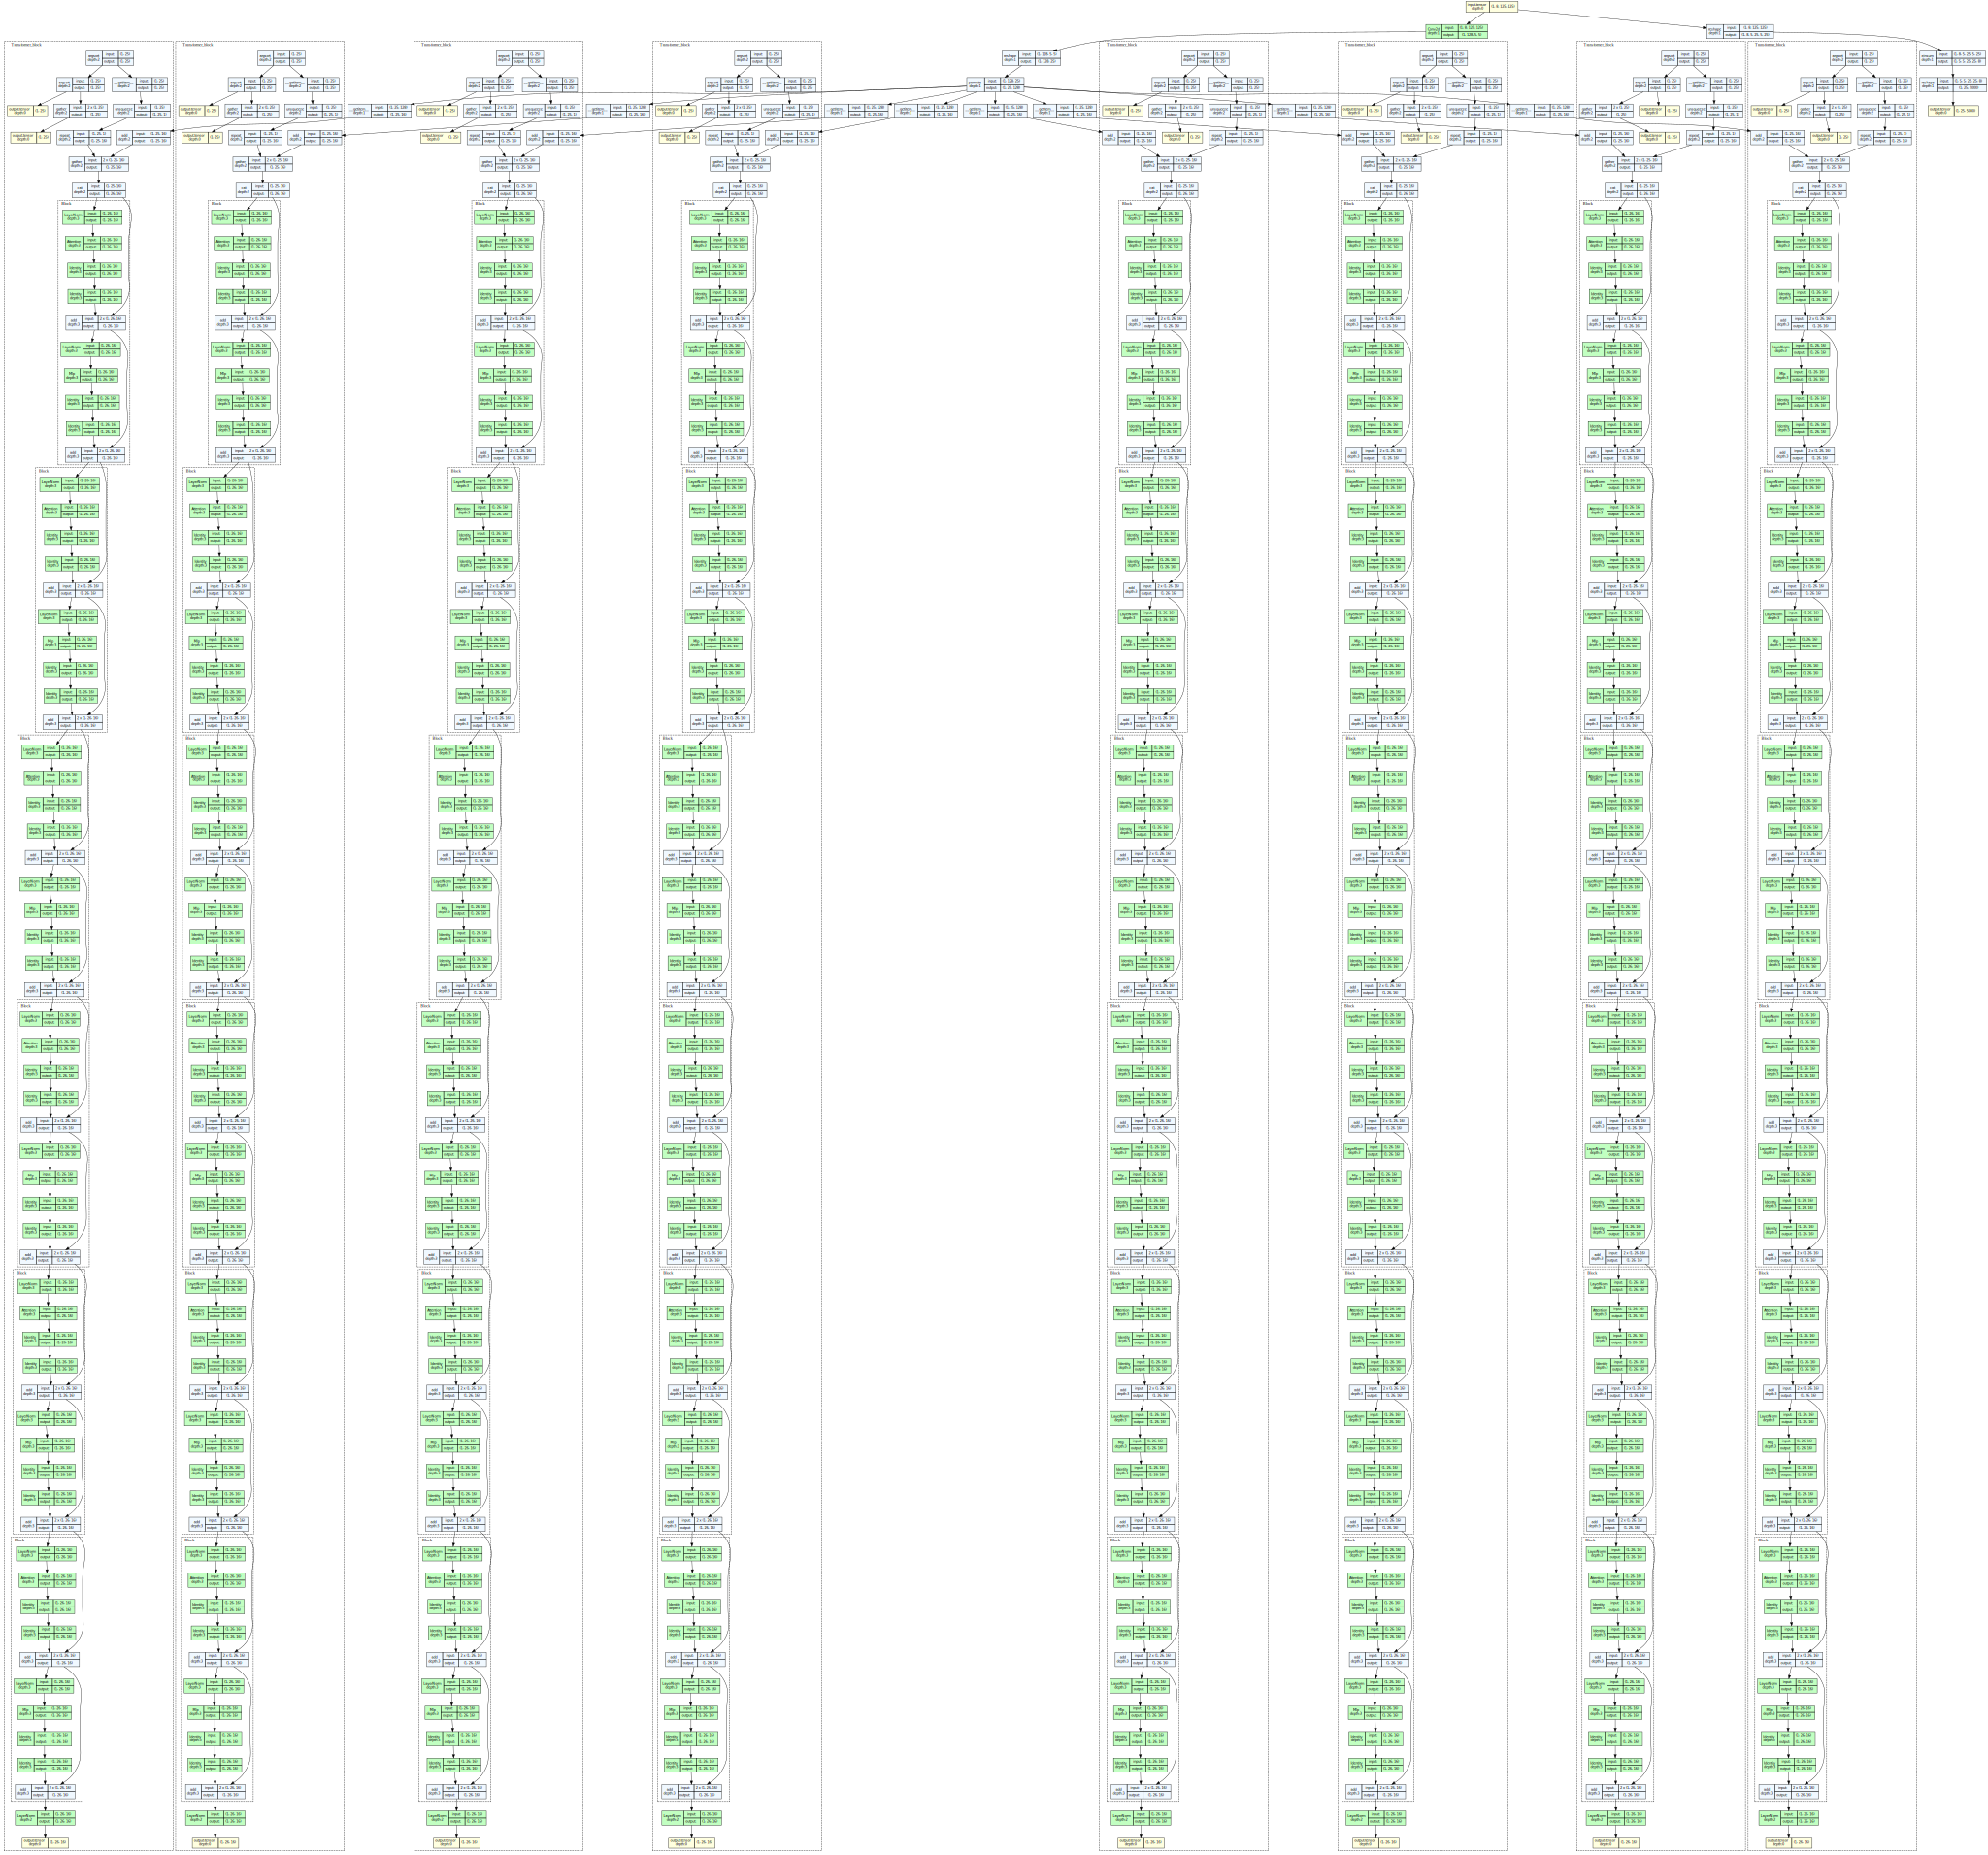

In [4]:
import torchvision
from torchview import draw_graph
from torchviz import make_dot
model_graph = draw_graph(model.encoder, input_size=(1,8,125,125), expand_nested=True)
model_graph.visual_graph

In [5]:
import os
import numpy as np
from PIL import Image
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import gc

def load_image(path):
    with Image.open(path) as f:
        img_array = np.array(f).reshape((125, 125, 8)).astype('float32')
    return img_array

def load_images_from_directory(directory, label):
    paths = [os.path.join(directory, file) for file in os.listdir(directory)][:30000]
    with ThreadPoolExecutor() as executor:
        images = list(tqdm(executor.map(load_image, paths), total=len(paths)))
    labels = [label] * len(images)
    return images, labels

# Load images from both directories
X_one, y_one = load_images_from_directory('/home/shashank/dataset/one/', 0)
X_two, y_two = load_images_from_directory('/home/shashank/dataset/two/', 1)

# Combine datasets
X = X_one + X_two
Y = y_one + y_two

test = np.array(X[55000:]).astype('float32')
test_lab = np.array(Y[55000:]).astype('float32')

X = X[:55000]
Y = Y[:55000]


100%|██████████| 30000/30000 [00:02<00:00, 12011.26it/s] 


In [6]:
from sklearn.utils import shuffle
X, Y = shuffle(X, Y, random_state = 42)
X_train = X[:int(len(X)*0.8)]
X_test = X[int(len(X)*0.8):len(X)]
Y_train = Y[:int(len(X)*0.8)]
Y_test = Y[int(len(X)*0.8):len(X)]
Y_train = np.array(Y_train).astype('float32')
Y_test = np.array(Y_test).astype('float32')
X_train = np.array(X_train).astype('float32')
X_test = np.array(X_test).astype('float32')

print(X_train.shape)
print(Y_train.shape)

(44000, 125, 125, 8)
(44000,)


In [7]:
# ##Test SET
# test = []
# test_labels = []
# for i in range(150000, 155000):
#     with Image.open((f'/home/shashank/dataset/one/{i}.png')) as img:
#         img_array = np.array(img).astype('float32')
#         test.append(img_array)
#         test_labels.append(0)

# for i in range(500000, 505000):
#     with Image.open((f'/home/shashank/dataset/two/{i}.png')) as img:
#         img_array = np.array(img).astype('float32')
#         test.append(img_array)
#         test_labels.append(1)
# test = np.array(test)
# test_labels = np.array(test_labels)

In [8]:
import os
import torch
import pandas as pd
# from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class Custom_Dataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_1 = torch.from_numpy(self.x[idx]).moveaxis(2, 0) / 255
        label = torch.tensor(self.y[idx])
            
        sample = {'img' : img_1, 'label' : label}
        
        return sample


t_dataset = Custom_Dataset(X_train, Y_train)
y_dataset = Custom_Dataset(X_test, Y_test)
t_dataloader = DataLoader(t_dataset, batch_size = 8)
# t_dataloader = DataLoader(t_dataset, batch_size = 8)
sample = t_dataset.__getitem__(1)
print((sample['img']).shape)
print(sample['label'])


torch.Size([8, 125, 125])
tensor(0.)


In [9]:
class FromPretrainedDecoder(nn.Module):
    def __init__(self, pretrained_model, hidden_dim, num_classes):
        super().__init__()
        self.pretrained_model = pretrained_model
        
        for param in self.pretrained_model.parameters():
            param.requires_grad = False
            
        self.linear1 = nn.Linear(hidden_dim, 32)
        self.linear = nn.Linear(32, num_classes)
        self.linear2 = nn.Linear(hidden_dim, num_classes)
        self.batchnorm = nn.BatchNorm1d(hidden_dim)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        # x = self.pretrained_model.encoder._process_input(x)
        n = x.shape[0]

        encoded_tensor, masks, ids, img= self.pretrained_model.encoder(x)
        op = torch.cat(encoded_tensor, axis = 2)
        # x = op[:,:1,:].squeeze(1)
        x = op.mean(axis = 1)
        x = self.batchnorm(x)
        x = self.relu(x)
        # x = self.sigmoid(self.linear(x))
        x = self.linear1(x)
        # x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.linear(x)
        
        return x

pretrained_model = FromPretrainedDecoder(pretrained_model=model,
                                         hidden_dim=128,
                                         num_classes=1)

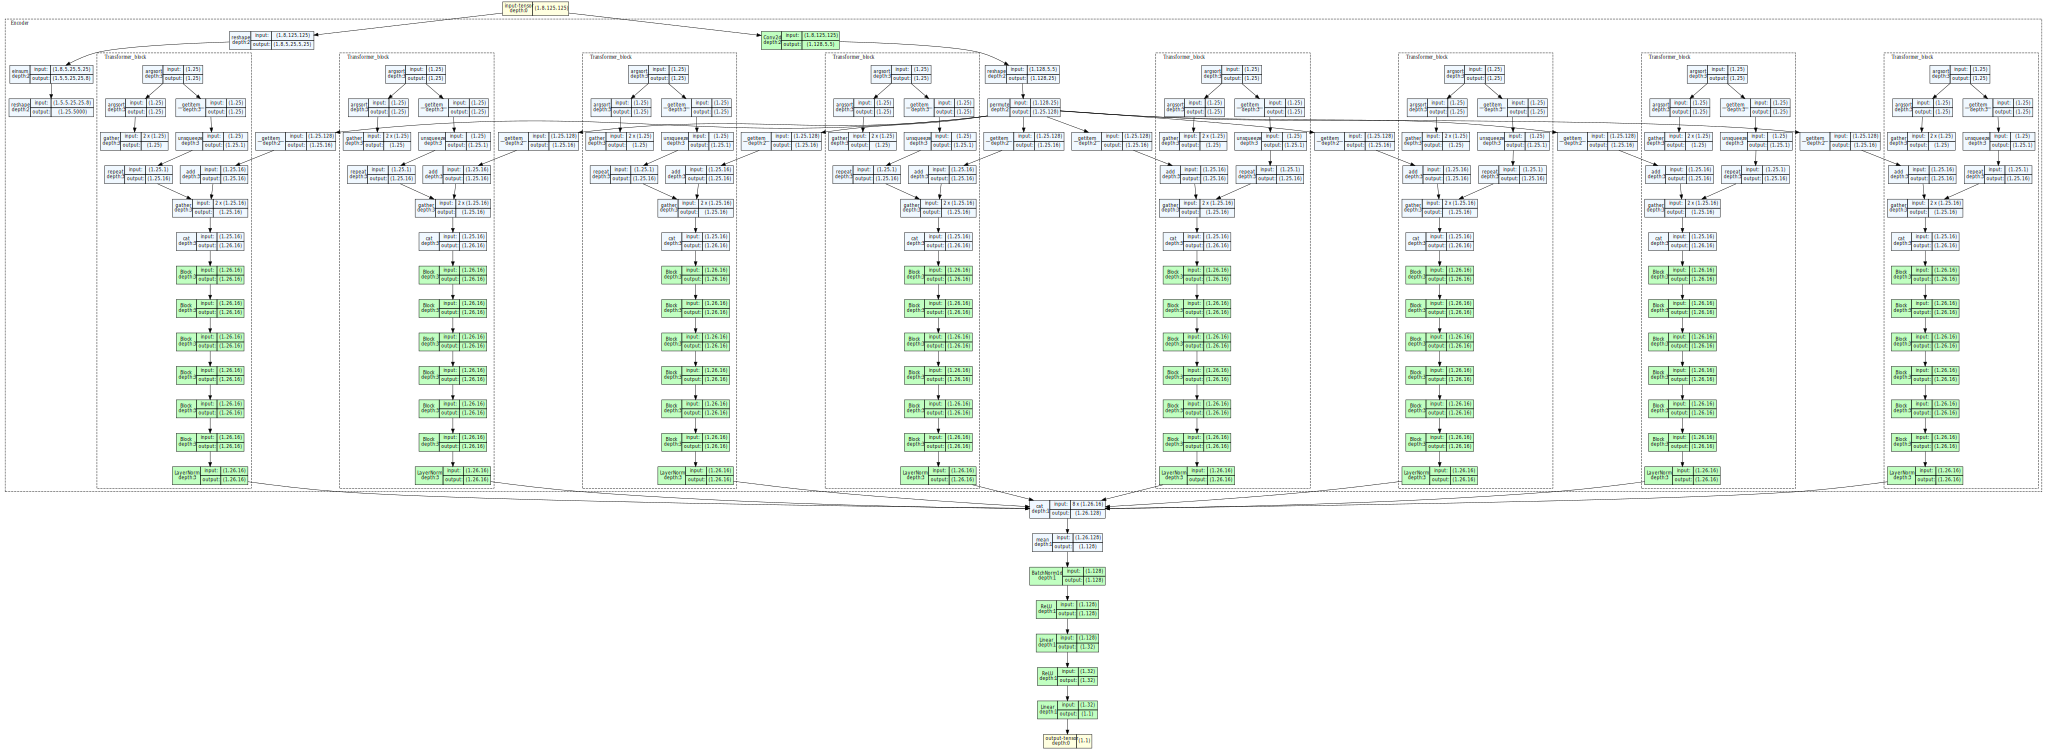

In [10]:
import torchvision
from torchview import draw_graph
from torchviz import make_dot

model_graph = draw_graph(pretrained_model, input_size=(1,8,125,125), expand_nested=True)
model_graph.visual_graph

In [11]:
# model.train()
for batch in t_dataloader:
    img = batch['img']
    lab = batch['label']
    break
pred = pretrained_model(img)
torch.sigmoid(pred)

tensor([[0.4731],
        [0.5040],
        [0.4618],
        [0.5472],
        [0.4884],
        [0.4430],
        [0.5266],
        [0.5136]], grad_fn=<SigmoidBackward0>)

In [12]:
criterion = nn.BCEWithLogitsLoss(reduction = "mean")
loss = criterion(pred.squeeze(), lab)
loss

tensor(0.7258, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [13]:
def reduce_fn(vals):
    # take average
    # xm.print(len(vals))
    return sum(vals) / len(vals)

In [14]:
def lr_lambda(epoch):
    warmup_epochs = 3
    decay_rate = 0.8
    if epoch < warmup_epochs:
        # Linear increase during warmup
        return float(epoch + 1) / warmup_epochs
    else:
        # Exponential decay after warmup
        return decay_rate ** (epoch - warmup_epochs + 1)

In [15]:
from tqdm import tqdm
from torchmetrics import Accuracy
def train_one_epoch(epoch, epochs, model, train_dataloader, valid_dataloader, scheduler, device, optimizer):
    train_loss = []
    valid_loss = []
    accuracy = Accuracy(task = 'binary').to(device)
    criterion = nn.BCEWithLogitsLoss(reduction = "mean")
    # criterion = nn.BCELoss()
    
    train_accuracies = []
    val_accuracies = []
    
    model.train()
    # scheduler.step()

    for step, batch in tqdm(enumerate(train_dataloader), desc=f'Epoch {epoch+1}/{epochs} (Train)', unit='batch'):
        image = batch['img'].to(device)
        label = batch['label'].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(image)
        outputs = outputs.squeeze()
        loss = criterion(outputs, label)

        loss.backward()
        xm.optimizer_step(optimizer)
        loss_reduced = xm.mesh_reduce('loss_reduce',loss.item(),reduce_fn) 
        # outputs_reduced = xm.mesh_reduce('outputs_reduce',outputs.item(),reduce_fn) 
        
        train_loss.append(loss_reduced)
        train_acc = accuracy(outputs, label)
        train_accuracies.append(train_acc.item())
        
        # if step%50 == 0:
        #     xm.master_print(f'Train_Batch: {step}, reduced_loss: {loss_reduced}, loss: {loss.item()},  outputs: {outputs[0]}')
        gc.collect()

    model.eval()
    with torch.no_grad():
        for step, batch in tqdm(enumerate(valid_dataloader), desc=f'Epoch {epoch+1}/{epochs} (Train)', unit='batch'):
            image = batch['img'].to(device)
            label = batch['label'].to(device).squeeze()
            outputs = model(image)
            outputs = outputs.squeeze()
            
            loss = criterion(outputs, label)
            loss_reduced = xm.mesh_reduce('loss_reduce',loss.item(),reduce_fn) 
            valid_loss.append(loss_reduced)
            
            val_acc = accuracy(outputs, label)
            val_accuracies.append(val_acc.item())
            
            # if step%10 == 0:
            #     xm.master_print(f'val_Batch: {step}, reduced_loss: {loss_reduced}, loss: {loss.item()}  outputs: {outputs[0]}')
            gc.collect()

    return np.mean(train_loss), np.mean(valid_loss) , np.mean(train_accuracies), np.mean(val_accuracies)


In [16]:
def data():


    ##Train Dataset
    train_dataset = Custom_Dataset(X_train, Y_train)
    
    ##Test Dataset
    test_dataset = Custom_Dataset(X_test, Y_test)
    
    ##Sampler
    train_sampler = torch.utils.data.distributed.DistributedSampler(
                                                                    train_dataset,
                                                                    num_replicas=xm.xrt_world_size(),
                                                                    rank=xm.get_ordinal(),
                                                                    shuffle = True
                                                                    )
    
    ##Train Dataloader
    dataloader_train = torch.utils.data.DataLoader(train_dataset,
                                                    batch_size=128,
                                                    sampler = train_sampler,
                                                    drop_last = True,
                                                    num_workers=1,
                                                    pin_memory = True)
    
    
    ##Sampler
    valid_sampler = torch.utils.data.distributed.DistributedSampler(
                                                                    test_dataset,
                                                                    num_replicas=xm.xrt_world_size(),
                                                                    rank=xm.get_ordinal(),
                                                                    shuffle = False
                                                                    )
    ##Test Dataloader
    dataloader_test = torch.utils.data.DataLoader(test_dataset,
                                                  sampler = valid_sampler,
                                                  batch_size=64,
                                                  drop_last = True,
                                                  num_workers=1,
                                                 )
    return dataloader_train, dataloader_test

In [17]:

def train_function(model, epochs, dev):
    lr = 1.5e-4
    num_train_steps = int(
        len(X_train) / 64 / xm.xrt_world_size() * epochs
    )

    lr = lr * xm.xrt_world_size()
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay = 0.005)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    train_dataloader, test_dataloader = data()
    
    xm.master_print(f'num_training_steps = {num_train_steps}, world_size={xm.xrt_world_size()}')
    device = dev
    model = model.to(device)
    
    train_loss = []
    valid_loss = []
    for epoch in (range(epochs)):
        gc.collect()
        para_loader = pl.ParallelLoader(train_dataloader, [device])
        train_loader = para_loader.per_device_loader(device)

        val_loader = pl.ParallelLoader(test_dataloader, [device])
        valid_loader = val_loader.per_device_loader(device)
        
        trn_loss, val_loss, trn_acc, val_acc = train_one_epoch(epoch, epochs, model, train_loader, valid_loader, scheduler, device, optimizer)
        
        scheduler.step()
        train_loss.append(trn_loss)
        valid_loss.append(val_loss)
        gc.collect()

        xm.master_print(f'Epoch {epoch+1}/{epochs}, Train Loss: {trn_loss:.4f}, Val Loss: {val_loss:.4f}, Train acc: {trn_acc:.4f}, Val acc: {val_acc:.4f},')
        with open('losses.txt', 'a') as f:
            f.write(f'Epoch {epoch+1}/{epochs}, Train Loss: {trn_loss:.4f}, Val Loss: {val_loss:.4f}\n')
        
    xm.rendezvous('save_model')
    xm.master_print('save model')
    xm.save(model.state_dict(), f'./Model_files/encoder_model_epoch.pth')

def _mp_fn(rank, flags):
    try:
        pretrained_model = FromPretrainedDecoder(pretrained_model=model,
                                         hidden_dim=128,
                                         num_classes=1)
        dev = xm.xla_device()
        pretrained_model = pretrained_model.to(dev)
        dataloader_train, dataloader_test = data()
        torch.set_default_tensor_type('torch.FloatTensor')
        train_function(pretrained_model, epochs=15, dev = dev)
        # xser.save(model.state_dict(), f"model.bin", master_only=True)
    except Exception as e:
        print(f"Exception in process {rank}: {e}")
        raise

if __name__ == '__main__':
    FLAGS = {}
    try:
        xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=8, start_method='fork')
    except Exception as e:
        print(f"Exception in main: {e}")

I0000 00:00:1719638880.256710 4042952 pjrt_api.cc:100] GetPjrtApi was found for tpu at /home/shashank/.local/lib/python3.10/site-packages/libtpu/libtpu.so
I0000 00:00:1719638880.256710 4042953 pjrt_api.cc:100] GetPjrtApi was found for tpu at /home/shashank/.local/lib/python3.10/site-packages/libtpu/libtpu.so


num_training_steps = 2578, world_size=4


Epoch 1/15 (Train): 85batch [01:12,  1.17batch/s]
Epoch 1/15 (Train): 85batch [01:11,  1.19batch/s]
Epoch 1/15 (Train): 85batch [01:12,  1.17batch/s]
Epoch 1/15 (Train): 85batch [01:12,  1.17batch/s]
Epoch 1/15 (Train): 42batch [00:40,  1.05batch/s]
Epoch 1/15 (Train): 42batch [00:40,  1.05batch/s]
Epoch 1/15 (Train): 42batch [00:39,  1.05batch/s]
Epoch 1/15 (Train): 42batch [00:40,  1.05batch/s]


Epoch 1/15, Train Loss: 0.6892, Val Loss: 0.6849, Train acc: 0.5434, Val acc: 0.5725,


Epoch 2/15 (Train): 85batch [00:49,  1.73batch/s]
Epoch 2/15 (Train): 85batch [00:49,  1.73batch/s]
Epoch 2/15 (Train): 85batch [00:48,  1.75batch/s]
Epoch 2/15 (Train): 85batch [00:49,  1.73batch/s]
Epoch 2/15 (Train): 42batch [00:15,  2.70batch/s]
Epoch 2/15 (Train): 42batch [00:15,  2.70batch/s]
Epoch 2/15 (Train): 42batch [00:15,  2.71batch/s]
Epoch 2/15 (Train): 42batch [00:15,  2.71batch/s]


Epoch 2/15, Train Loss: 0.6618, Val Loss: 0.6397, Train acc: 0.6187, Val acc: 0.6410,


Epoch 3/15 (Train): 85batch [00:44,  1.89batch/s]
Epoch 3/15 (Train): 85batch [00:44,  1.89batch/s]
Epoch 3/15 (Train): 85batch [00:44,  1.90batch/s]
Epoch 3/15 (Train): 85batch [00:44,  1.91batch/s]
Epoch 3/15 (Train): 42batch [00:19,  2.10batch/s]
Epoch 3/15 (Train): 42batch [00:19,  2.10batch/s]
Epoch 3/15 (Train): 42batch [00:20,  2.09batch/s]
Epoch 3/15 (Train): 42batch [00:20,  2.09batch/s]


Epoch 3/15, Train Loss: 0.6198, Val Loss: 0.6032, Train acc: 0.6736, Val acc: 0.6894,


Epoch 4/15 (Train): 85batch [00:49,  1.71batch/s]
Epoch 4/15 (Train): 85batch [00:49,  1.71batch/s]
Epoch 4/15 (Train): 85batch [00:49,  1.72batch/s]
Epoch 4/15 (Train): 85batch [00:48,  1.74batch/s]
Epoch 4/15 (Train): 42batch [00:23,  1.76batch/s]
Epoch 4/15 (Train): 42batch [00:23,  1.76batch/s]
Epoch 4/15 (Train): 42batch [00:23,  1.77batch/s]
Epoch 4/15 (Train): 42batch [00:23,  1.76batch/s]


Epoch 4/15, Train Loss: 0.6014, Val Loss: 0.5961, Train acc: 0.6911, Val acc: 0.7035,


Epoch 5/15 (Train): 85batch [00:43,  1.93batch/s]
Epoch 5/15 (Train): 85batch [00:43,  1.97batch/s]
Epoch 5/15 (Train): 85batch [00:44,  1.93batch/s]
Epoch 5/15 (Train): 85batch [00:43,  1.95batch/s]
Epoch 5/15 (Train): 42batch [00:15,  2.70batch/s]
Epoch 5/15 (Train): 42batch [00:15,  2.71batch/s]
Epoch 5/15 (Train): 42batch [00:15,  2.71batch/s]
Epoch 5/15 (Train): 42batch [00:15,  2.71batch/s]


Epoch 5/15, Train Loss: 0.5961, Val Loss: 0.5929, Train acc: 0.6957, Val acc: 0.7094,


Epoch 6/15 (Train): 85batch [00:46,  1.82batch/s]
Epoch 6/15 (Train): 85batch [00:46,  1.82batch/s]
Epoch 6/15 (Train): 85batch [00:46,  1.84batch/s]
Epoch 6/15 (Train): 85batch [00:46,  1.84batch/s]
Epoch 6/15 (Train): 42batch [00:16,  2.61batch/s]
Epoch 6/15 (Train): 42batch [00:16,  2.61batch/s]
Epoch 6/15 (Train): 42batch [00:16,  2.61batch/s]
Epoch 6/15 (Train): 42batch [00:16,  2.61batch/s]


Epoch 6/15, Train Loss: 0.5934, Val Loss: 0.5910, Train acc: 0.6970, Val acc: 0.7121,


Epoch 7/15 (Train): 85batch [00:44,  1.91batch/s]
Epoch 7/15 (Train): 85batch [00:43,  1.93batch/s]
Epoch 7/15 (Train): 85batch [00:44,  1.91batch/s]
Epoch 7/15 (Train): 85batch [00:44,  1.92batch/s]
Epoch 7/15 (Train): 42batch [00:21,  1.92batch/s]
Epoch 7/15 (Train): 42batch [00:21,  1.92batch/s]
Epoch 7/15 (Train): 42batch [00:21,  1.92batch/s]
Epoch 7/15 (Train): 42batch [00:21,  1.92batch/s]


Epoch 7/15, Train Loss: 0.5916, Val Loss: 0.5898, Train acc: 0.6988, Val acc: 0.7121,


Epoch 8/15 (Train): 85batch [00:39,  2.13batch/s]
Epoch 8/15 (Train): 85batch [00:39,  2.16batch/s]
Epoch 8/15 (Train): 85batch [00:39,  2.15batch/s]
Epoch 8/15 (Train): 85batch [00:39,  2.13batch/s]
Epoch 8/15 (Train): 42batch [00:18,  2.32batch/s]
Epoch 8/15 (Train): 42batch [00:18,  2.33batch/s]
Epoch 8/15 (Train): 42batch [00:18,  2.32batch/s]
Epoch 8/15 (Train): 42batch [00:18,  2.32batch/s]


Epoch 8/15, Train Loss: 0.5903, Val Loss: 0.5889, Train acc: 0.7006, Val acc: 0.7132,


Epoch 9/15 (Train): 85batch [00:43,  1.93batch/s]
Epoch 9/15 (Train): 85batch [00:43,  1.94batch/s]
Epoch 9/15 (Train): 85batch [00:43,  1.94batch/s]
Epoch 9/15 (Train): 85batch [00:44,  1.92batch/s]
Epoch 9/15 (Train): 42batch [00:21,  1.97batch/s]
Epoch 9/15 (Train): 42batch [00:21,  1.99batch/s]
Epoch 9/15 (Train): 42batch [00:21,  1.97batch/s]
Epoch 9/15 (Train): 42batch [00:21,  1.97batch/s]


Epoch 9/15, Train Loss: 0.5894, Val Loss: 0.5881, Train acc: 0.7021, Val acc: 0.7132,


Epoch 10/15 (Train): 85batch [00:48,  1.77batch/s]
Epoch 10/15 (Train): 85batch [00:47,  1.77batch/s]
Epoch 10/15 (Train): 85batch [00:47,  1.79batch/s]
Epoch 10/15 (Train): 85batch [00:47,  1.78batch/s]
Epoch 10/15 (Train): 42batch [00:22,  1.83batch/s]
Epoch 10/15 (Train): 42batch [00:22,  1.83batch/s]
Epoch 10/15 (Train): 42batch [00:22,  1.84batch/s]
Epoch 10/15 (Train): 42batch [00:23,  1.81batch/s]


Epoch 10/15, Train Loss: 0.5886, Val Loss: 0.5876, Train acc: 0.7031, Val acc: 0.7132,


Epoch 11/15 (Train): 85batch [00:35,  2.39batch/s]
Epoch 11/15 (Train): 85batch [00:36,  2.35batch/s]
Epoch 11/15 (Train): 85batch [00:35,  2.38batch/s]
Epoch 11/15 (Train): 85batch [00:36,  2.35batch/s]
Epoch 11/15 (Train): 42batch [00:23,  1.77batch/s]
Epoch 11/15 (Train): 42batch [00:23,  1.77batch/s]
Epoch 11/15 (Train): 42batch [00:23,  1.77batch/s]
Epoch 11/15 (Train): 42batch [00:23,  1.77batch/s]


Epoch 11/15, Train Loss: 0.5881, Val Loss: 0.5871, Train acc: 0.7032, Val acc: 0.7139,


Epoch 12/15 (Train): 85batch [00:43,  1.98batch/s]
Epoch 12/15 (Train): 85batch [00:42,  1.99batch/s]
Epoch 12/15 (Train): 85batch [00:43,  1.97batch/s]
Epoch 12/15 (Train): 85batch [00:41,  2.02batch/s]
Epoch 12/15 (Train): 42batch [00:18,  2.33batch/s]
Epoch 12/15 (Train): 42batch [00:18,  2.33batch/s]
Epoch 12/15 (Train): 42batch [00:18,  2.33batch/s]
Epoch 12/15 (Train): 42batch [00:18,  2.32batch/s]


Epoch 12/15, Train Loss: 0.5877, Val Loss: 0.5868, Train acc: 0.7037, Val acc: 0.7121,


Epoch 13/15 (Train): 85batch [00:48,  1.75batch/s]
Epoch 13/15 (Train): 85batch [00:48,  1.74batch/s]
Epoch 13/15 (Train): 85batch [00:48,  1.76batch/s]
Epoch 13/15 (Train): 85batch [00:48,  1.75batch/s]
Epoch 13/15 (Train): 42batch [00:21,  1.92batch/s]
Epoch 13/15 (Train): 42batch [00:21,  1.92batch/s]
Epoch 13/15 (Train): 42batch [00:21,  1.92batch/s]
Epoch 13/15 (Train): 42batch [00:21,  1.93batch/s]


Epoch 13/15, Train Loss: 0.5873, Val Loss: 0.5866, Train acc: 0.7040, Val acc: 0.7121,


Epoch 14/15 (Train): 85batch [00:42,  2.01batch/s]
Epoch 14/15 (Train): 85batch [00:42,  2.01batch/s]
Epoch 14/15 (Train): 85batch [00:41,  2.03batch/s]
Epoch 14/15 (Train): 85batch [00:41,  2.03batch/s]
Epoch 14/15 (Train): 42batch [00:16,  2.62batch/s]
Epoch 14/15 (Train): 42batch [00:16,  2.61batch/s]
Epoch 14/15 (Train): 42batch [00:16,  2.61batch/s]
Epoch 14/15 (Train): 42batch [00:16,  2.62batch/s]


Epoch 14/15, Train Loss: 0.5871, Val Loss: 0.5864, Train acc: 0.7056, Val acc: 0.7135,


Epoch 15/15 (Train): 85batch [00:35,  2.36batch/s]
Epoch 15/15 (Train): 85batch [00:36,  2.36batch/s]
Epoch 15/15 (Train): 85batch [00:35,  2.39batch/s]
Epoch 15/15 (Train): 85batch [00:35,  2.38batch/s]
Epoch 15/15 (Train): 42batch [00:19,  2.13batch/s]
Epoch 15/15 (Train): 42batch [00:19,  2.13batch/s]
Epoch 15/15 (Train): 42batch [00:19,  2.12batch/s]
Epoch 15/15 (Train): 42batch [00:19,  2.13batch/s]


Epoch 15/15, Train Loss: 0.5869, Val Loss: 0.5863, Train acc: 0.7047, Val acc: 0.7147,
save model
